In [1]:
# XWhiff Model Development - Exploratory Data Analysis
# This notebook explores pitch tracking data to build a model predicting swing-and-miss probability
# 
# Import necessary libraries for data manipulation, modeling, and visualization
import pandas as pd                    # Data manipulation and analysis
import numpy as np                     # Numerical operations
import xgboost as xgb                  # Gradient boosting framework
from xgboost import XGBClassifier      # XGBoost classifier for binary classification
from sklearn.linear_model import LogisticRegression  # Linear model for comparison
import matplotlib.pyplot as plt        # Basic plotting functionality
import seaborn as sns                  # Statistical data visualization

In [2]:
data_2024 = pd.read_csv('./csvs/verified_2024.csv',low_memory=False,on_bad_lines='skip')

In [3]:
# Create a working copy of the data to preserve the original dataset
# This allows us to make modifications without affecting the source data
baseball = data_2024.copy()

In [4]:
# Filter data to only include Division 1 college baseball
# This ensures consistent competition level and data quality for our model
baseball = baseball[baseball['Level'] == 'D1']

In [5]:
# Examine all available columns in the dataset
# This helps us understand what features are available for analysis
baseball.columns

Index(['PitchNo', 'Date', 'Time', 'PAofInning', 'PitchofPA', 'Pitcher',
       'PitcherId', 'PitcherThrows', 'PitcherTeam', 'Batter',
       ...
       'ThrowTrajectoryZc1', 'ThrowTrajectoryZc2', 'PitchReleaseConfidence',
       'PitchLocationConfidence', 'PitchMovementConfidence',
       'HitLaunchConfidence', 'HitLandingConfidence',
       'CatcherThrowCatchConfidence', 'CatcherThrowReleaseConfidence',
       'CatcherThrowLocationConfidence'],
      dtype='object', length=167)

In [6]:
# Select relevant features for swing-and-miss analysis
# These columns capture key aspects that influence whiff probability:
# - Pitcher/batter characteristics: handedness, game situation
# - Pitch characteristics: type, velocity, spin, movement
# - Location: release point, plate location, approach angles
pitching = baseball[['PitcherThrows',     # Pitcher handedness (L/R)
                     'BatterSide',        # Batter handedness (L/R)
                     'Outs',              # Number of outs in inning
                     'Balls',             # Ball count
                     'Strikes',           # Strike count
                     'TaggedPitchType',   # Pitch classification
                     'PitchCall',         # Outcome of pitch (ball, strike, in play, etc.)
                     'RelSpeed',          # Release velocity (mph)
                     'VertRelAngle',      # Vertical release angle
                     'HorzRelAngle',      # Horizontal release angle
                     'SpinRate',          # Spin rate (rpm)
                     'SpinAxis',          # Spin axis orientation
                     'RelHeight',         # Release height
                     'RelSide',           # Release side
                     'Extension',         # Extension from mound
                     'InducedVertBreak',  # Vertical movement from spin
                     'HorzBreak',         # Horizontal movement
                     'PlateLocHeight',    # Height location at plate
                     'PlateLocSide',      # Side location at plate
                     'VertApprAngle',     # Vertical approach angle
                     'HorzApprAngle',     # Horizontal approach angle
                     'PitcherId']]        # Unique pitcher identifier

In [7]:
pitching.dtypes

PitcherThrows        object
BatterSide           object
Outs                  int64
Balls                 int64
Strikes               int64
TaggedPitchType      object
PitchCall            object
RelSpeed            float64
VertRelAngle        float64
HorzRelAngle        float64
SpinRate            float64
SpinAxis            float64
RelHeight           float64
RelSide             float64
Extension           float64
InducedVertBreak    float64
HorzBreak           float64
PlateLocHeight      float64
PlateLocSide        float64
VertApprAngle       float64
HorzApprAngle       float64
PitcherId           float64
dtype: object

In [8]:
# Remove rows with missing values to ensure clean data for modeling
# Note: This generates a warning about modifying a slice, but it's acceptable for our analysis
pitching.dropna(inplace=True)

/var/folders/q5/0z0yqctd3xb1wgpb7qcl0g140000gn/T/ipykernel_44178/2840524411.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitching.dropna(inplace=True)


In [9]:
pitching['PitchCall'].value_counts()

PitchCall
BallCalled              505068
StrikeCalled            237692
InPlay                  231129
FoulBallNotFieldable    171047
StrikeSwinging          138273
FoulBall                 37707
BallinDirt               14570
HitByPitch               11551
FoulBallFieldable         3525
BallIntentional            132
Undefined                   43
StrkeSwinging                1
StriekC                      1
BattersInterference          1
Name: count, dtype: int64

In [10]:
# Clean data quality issues - fix misspelled pitch call
# "StrkeSwinging" should be "StrikeSwinging" for consistency
pitching['PitchCall'] = pitching['PitchCall'].replace('StrkeSwinging', 'StrikeSwinging')

/var/folders/q5/0z0yqctd3xb1wgpb7qcl0g140000gn/T/ipykernel_44178/3981682121.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitching['PitchCall'] = pitching['PitchCall'].replace('StrkeSwinging','StrikeSwinging')


In [11]:
pitching['PitcherThrows'].value_counts()

PitcherThrows
Right    983593
Left     366825
Both        322
Name: count, dtype: int64

In [12]:
# Remove ambiguous pitcher handedness entries
# 'Both' is not a valid handedness for modeling purposes
pitching = pitching[pitching['PitcherThrows'] != 'Both']

In [13]:
pitching['TaggedPitchType'].value_counts()

TaggedPitchType
Fastball            597420
Slider              300557
ChangeUp            149086
Curveball            86003
Sinker               73273
Undefined            43375
Cutter               43177
FourSeamFastBall     38476
TwoSeamFastBall      11615
Splitter              6502
Other                  614
Knuckleball            168
OneSeamFastBall        152
Name: count, dtype: int64

In [14]:
# Standardize pitch type names and filter to main pitch types
# This ensures consistent naming conventions across the dataset

# Fix inconsistent pitch type naming
pitching['TaggedPitchType'] = pitching['TaggedPitchType'].replace('FourSeamFastBall', 'Fastball')
pitching['TaggedPitchType'] = pitching['TaggedPitchType'].replace('TwoSeamFastBall', 'Sinker')
pitching['TaggedPitchType'] = pitching['TaggedPitchType'].replace('Changeup', 'ChangeUp')

# Keep only the six main pitch types for analysis
# This removes untagged/rare pitches that could introduce noise
valid_pitches = ['Fastball', 'Slider', 'ChangeUp', 'Sinker', 'Cutter', 'Curveball']
pitching = pitching[pitching['TaggedPitchType'].isin(valid_pitches)]

# Verify the cleaned pitch type distribution
pitching['TaggedPitchType'].value_counts()

TaggedPitchType
Fastball     635896
Slider       300557
ChangeUp     149086
Curveball     86003
Sinker        84888
Cutter        43177
Name: count, dtype: int64

In [15]:

pitching['BatterSide'].value_counts()

BatterSide
Right    817227
Left     482380
Name: count, dtype: int64

In [16]:
#remove data where the batter's side is undefeined
pitching = pitching[pitching['BatterSide'] != 'Undefined']

In [17]:
pitching['RelSpeed'].value_counts()
pitching['RelSpeed'].min()


45.96822

In [18]:
# Remove unrealistic velocity outliers
# At D1 college level, no legitimate pitch should be below 60 mph
# This likely represents tracking errors or warmup pitches
pitching = pitching[pitching['RelSpeed'] > 60]
pitching['RelSpeed'].min()

60.01141

In [19]:
pitching = pitching[pitching['PitchCall'] != 'Undefined']

In [20]:
#describe data
pitching.describe()

,Outs,Balls,Strikes,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,VertApprAngle,HorzApprAngle,PitcherId
count,1.299546e+06,1.299546e+06,1.299546e+06,1.299546e+06,1.299546e+06,1.299546e+06,1.299546e+06,1.299546e+06,1.299546e+06,1.299546e+06,1.299546e+06,1.299546e+06,1.299546e+06,1.299546e+06,1.299546e+06,1.299546e+06,1.299546e+06,1.299546e+06
mean,9.802439e-01,9.193572e-01,8.420387e-01,8.532005e+01,-9.198832e-01,-1.060446e+00,2.191431e+03,1.786717e+02,5.685668e+00,7.474503e-01,5.751422e+00,8.749659e+00,2.040386e+00,2.272687e+00,-6.862291e-02,-6.597163e+00,-6.928479e-01,1.056458e+09
std,8.171181e-01,9.868009e-01,8.197672e-01,5.817376e+00,1.632472e+00,2.667798e+00,2.962747e+02,7.357574e+01,5.539860e-01,1.791949e+00,5.781299e-01,9.203948e+00,1.202004e+01,1.015028e+00,9.817966e-01,1.819318e+00,2.143882e+00,6.516225e+09
min,0.000000e+00,0.000000e+00,0.000000e+00,6.001141e+01,-1.222955e+01,-1.096147e+01,6.166803e+02,2.663000e-03,1.422540e+00,-6.744630e+00,-1.110660e+00,-5.444653e+01,-5.782787e+01,-8.257320e+00,-8.447950e+00,-1.861795e+01,-1.092685e+01,7.264000e+03
25%,0.000000e+00,0.000000e+00,0.000000e+00,8.076267e+01,-2.055215e+00,-2.993353e+00,2.043804e+03,1.233564e+02,5.393150e+00,-8.569300e-01,5.360832e+00,2.232840e+00,-8.513700e+00,1.615290e+00,-7.165075e-01,-7.800313e+00,-2.087065e+00,8.135750e+05
50%,1.000000e+00,1.000000e+00,1.000000e+00,8.626551e+01,-1.023640e+00,-1.731415e+00,2.210155e+03,1.989840e+02,5.727430e+00,1.372030e+00,5.756055e+00,1.000089e+01,3.820320e+00,2.273980e+00,-6.975000e-02,-6.404817e+00,-6.930740e-01,1.000073e+09
75%,2.000000e+00,2.000000e+00,2.000000e+00,8.998416e+01,1.188198e-01,8.337938e-01,2.367182e+03,2.311086e+02,6.040710e+00,1.983200e+00,6.143980e+00,1.634331e+01,1.252087e+01,2.931560e+00,5.780000e-01,-5.272295e+00,6.158515e-01,1.000127e+09
max,3.000000e+00,4.000000e+00,4.000000e+00,1.018115e+02,1.055297e+01,1.131705e+01,3.589561e+03,3.599984e+02,8.719460e+00,5.745280e+00,1.315134e+01,6.174393e+01,3.569620e+01,1.058726e+01,1.262111e+01,2.362432e+00,1.193248e+01,9.000026e+10


In [21]:
# Create binary target variable for swing-and-miss prediction
# whiff = 1 if the pitch resulted in a swinging strike (swing and miss)
# whiff = 0 for all other outcomes (contact, called strikes, balls, etc.)
pitching['whiff'] = np.where(pitching['PitchCall'] == 'StrikeSwinging', 1, 0)
pitching

,PitcherThrows,BatterSide,Outs,Balls,Strikes,TaggedPitchType,PitchCall,RelSpeed,VertRelAngle,HorzRelAngle,...,RelSide,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,VertApprAngle,HorzApprAngle,PitcherId,whiff
0,Right,Right,0,0,0,Slider,BallCalled,86.34831,-5.087035,-0.556059,...,0.28503,5.20061,-1.26150,-6.71201,-1.24052,-0.79734,-12.231122,-1.751516,1.000234e+09,0
1,Right,Right,0,1,0,Fastball,StrikeCalled,94.49974,-3.133086,-0.492520,...,0.46429,5.83655,20.20828,3.49654,3.00046,0.29788,-5.365324,0.134391,1.000234e+09,0
2,Right,Right,0,1,1,Fastball,FoulBallNotFieldable,94.81021,-3.910073,-1.135525,...,0.21782,5.67326,22.06875,-0.43740,2.48669,-0.87744,-5.815582,-1.213668,1.000234e+09,0
3,Right,Right,0,1,2,Slider,FoulBallNotFieldable,86.30865,-1.385858,-0.791508,...,0.12225,5.43599,2.34610,-6.38485,2.69703,-1.15108,-7.862841,-1.929632,1.000234e+09,0
4,Right,Right,0,1,2,Slider,BallCalled,87.45870,-4.605749,-1.323250,...,0.15737,5.28786,0.27646,-4.37162,-0.43496,-1.44974,-11.264591,-2.102031,1.000234e+09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506010,Right,Left,1,0,2,Fastball,StrikeSwinging,92.18631,0.167760,-2.363777,...,1.48251,5.16822,12.64422,18.25938,3.18957,0.77831,-3.753137,0.867156,6.945510e+05,1
1506011,Right,Right,2,0,0,Fastball,StrikeCalled,92.64280,-0.263162,-3.510955,...,1.38315,5.05159,15.40280,13.05642,3.09837,-0.84427,-3.653929,-1.209960,6.945510e+05,0
1506012,Right,Right,2,0,1,Fastball,StrikeSwinging,93.60782,-0.195835,-2.925634,...,1.12860,5.29399,17.26068,10.25316,3.60768,-0.76626,-3.090463,-1.109277,6.945510e+05,1
1506013,Right,Right,2,0,2,Fastball,BallCalled,92.70635,1.555863,-3.913135,...,1.39461,5.42663,16.00694,10.33784,4.86704,-1.41462,-1.669483,-2.081033,6.945510e+05,0


In [22]:
# Create a count feature combining balls and strikes
# Format: "balls-strikes" (e.g., "2-1", "3-2")
# Count situations significantly influence batter approach and swing decisions
pitching['count'] = pitching['Balls'].astype(str) + "-" + pitching['Strikes'].astype(str)
pitching

,PitcherThrows,BatterSide,Outs,Balls,Strikes,TaggedPitchType,PitchCall,RelSpeed,VertRelAngle,HorzRelAngle,...,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,VertApprAngle,HorzApprAngle,PitcherId,whiff,count
0,Right,Right,0,0,0,Slider,BallCalled,86.34831,-5.087035,-0.556059,...,5.20061,-1.26150,-6.71201,-1.24052,-0.79734,-12.231122,-1.751516,1.000234e+09,0,0-0
1,Right,Right,0,1,0,Fastball,StrikeCalled,94.49974,-3.133086,-0.492520,...,5.83655,20.20828,3.49654,3.00046,0.29788,-5.365324,0.134391,1.000234e+09,0,1-0
2,Right,Right,0,1,1,Fastball,FoulBallNotFieldable,94.81021,-3.910073,-1.135525,...,5.67326,22.06875,-0.43740,2.48669,-0.87744,-5.815582,-1.213668,1.000234e+09,0,1-1
3,Right,Right,0,1,2,Slider,FoulBallNotFieldable,86.30865,-1.385858,-0.791508,...,5.43599,2.34610,-6.38485,2.69703,-1.15108,-7.862841,-1.929632,1.000234e+09,0,1-2
4,Right,Right,0,1,2,Slider,BallCalled,87.45870,-4.605749,-1.323250,...,5.28786,0.27646,-4.37162,-0.43496,-1.44974,-11.264591,-2.102031,1.000234e+09,0,1-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506010,Right,Left,1,0,2,Fastball,StrikeSwinging,92.18631,0.167760,-2.363777,...,5.16822,12.64422,18.25938,3.18957,0.77831,-3.753137,0.867156,6.945510e+05,1,0-2
1506011,Right,Right,2,0,0,Fastball,StrikeCalled,92.64280,-0.263162,-3.510955,...,5.05159,15.40280,13.05642,3.09837,-0.84427,-3.653929,-1.209960,6.945510e+05,0,0-0
1506012,Right,Right,2,0,1,Fastball,StrikeSwinging,93.60782,-0.195835,-2.925634,...,5.29399,17.26068,10.25316,3.60768,-0.76626,-3.090463,-1.109277,6.945510e+05,1,0-1
1506013,Right,Right,2,0,2,Fastball,BallCalled,92.70635,1.555863,-3.913135,...,5.42663,16.00694,10.33784,4.86704,-1.41462,-1.669483,-2.081033,6.945510e+05,0,0-2


In [23]:
# Convert handedness variables to categorical data type
# This is more memory efficient and helps ML algorithms understand these are discrete categories
pitching['PitcherThrows'] = pitching['PitcherThrows'].astype('category')
pitching['BatterSide'] = pitching['BatterSide'].astype('category')

# Verify the updated data types
pitching.dtypes

PitcherThrows       category
BatterSide          category
Outs                   int64
Balls                  int64
Strikes                int64
TaggedPitchType       object
PitchCall             object
RelSpeed             float64
VertRelAngle         float64
HorzRelAngle         float64
SpinRate             float64
SpinAxis             float64
RelHeight            float64
RelSide              float64
Extension            float64
InducedVertBreak     float64
HorzBreak            float64
PlateLocHeight       float64
PlateLocSide         float64
VertApprAngle        float64
HorzApprAngle        float64
PitcherId            float64
whiff                  int64
count                 object
dtype: object

In [24]:
# Calculate correlation matrix for numerical features
# This helps identify multicollinearity and relationships between features
corr = pitching.select_dtypes(include=['float64'])
corr_matrix = corr.corr()
corr_matrix

,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,VertApprAngle,HorzApprAngle,PitcherId
RelSpeed,1.000000,-0.606330,-0.153290,0.062298,0.270794,0.143505,0.072872,0.298149,0.706453,0.294540,0.189428,0.047804,0.675093,0.104571,0.011037
VertRelAngle,-0.606330,1.000000,0.090317,0.058551,-0.173510,-0.462890,0.014849,-0.263436,-0.648944,-0.176473,0.451225,0.073247,-0.056889,-0.064657,0.007339
HorzRelAngle,-0.153290,0.090317,1.000000,-0.034497,-0.282878,0.047932,-0.878879,-0.084377,-0.036758,-0.621455,0.058101,0.291751,-0.041924,0.620603,0.022839
SpinRate,0.062298,0.058551,-0.034497,1.000000,-0.198412,0.024992,0.086054,-0.183412,-0.150303,-0.142804,-0.001925,-0.077308,-0.060258,-0.185701,-0.005531
SpinAxis,0.270794,-0.173510,-0.282878,-0.198412,1.000000,-0.064528,0.056643,0.144461,0.277229,0.797648,0.047525,0.205777,0.249857,0.446614,-0.003744
RelHeight,0.143505,-0.462890,0.047932,0.024992,-0.064528,1.000000,-0.061129,-0.013717,0.212221,-0.024700,0.077886,-0.014534,-0.138202,0.035036,-0.020691
RelSide,0.072872,0.014849,-0.878879,0.086054,0.056643,-0.061129,1.000000,0.039037,-0.050318,0.415625,-0.012542,0.025016,0.011157,-0.675522,-0.022064
Extension,0.298149,-0.263436,-0.084377,-0.183412,0.144461,-0.013717,0.039037,1.000000,0.341306,0.144054,0.074282,0.014437,0.294826,0.040953,-0.010689
InducedVertBreak,0.706453,-0.648944,-0.036758,-0.150303,0.277229,0.212221,-0.050318,0.341306,1.000000,0.222033,0.250149,0.044671,0.731493,0.176940,-0.009146
HorzBreak,0.294540,-0.176473,-0.621455,-0.142804,0.797648,-0.024700,0.415625,0.144054,0.222033,1.000000,0.033711,0.209535,0.210911,0.228591,-0.020314


<Axes: >

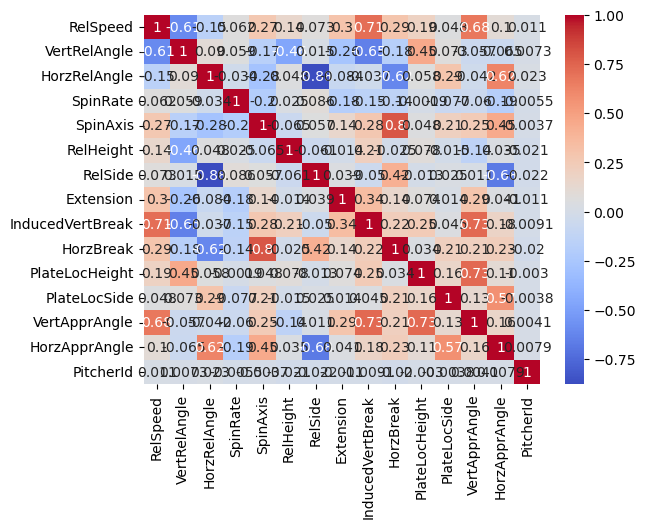

In [25]:
# Visualize correlation matrix as a heatmap
# Red indicates positive correlation, blue indicates negative correlation
# This helps identify which features are highly correlated (potential redundancy)
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")

In [26]:
# Optional: Create pairwise plots for deeper feature relationship analysis
# Commented out due to computational intensity with large datasets
# sns.pairplot(corr, diag_kind='kde')

Text(0, 0.5, 'Count (hundred-thousands)')

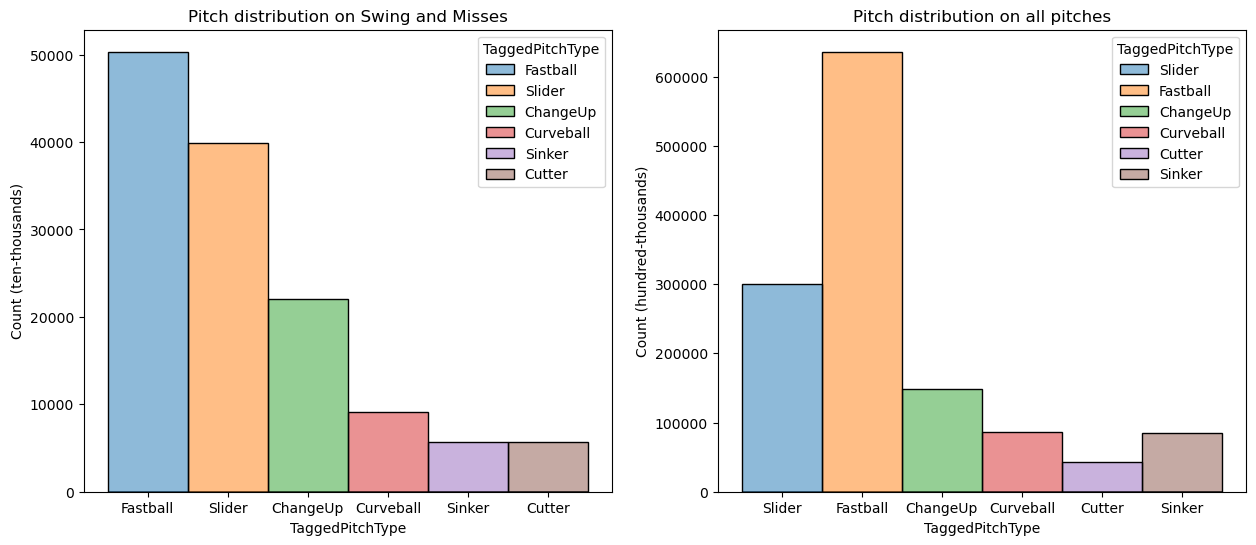

In [27]:
# Analyze pitch type distribution for swing-and-miss outcomes
# This comparison shows which pitch types generate the most whiffs vs overall usage

# Filter to only swing-and-miss pitches
swings = pitching[pitching['whiff'] == 1]

# Create side-by-side comparison plots
plt.figure(figsize=(15, 6))

# Left plot: Distribution of pitch types that resulted in swing-and-miss
plt.subplot(1, 2, 1)
sns.histplot(data=swings, x='TaggedPitchType', hue='TaggedPitchType')
plt.title('Pitch Distribution on Swing and Misses')
plt.ylabel('Count (ten-thousands)')

# Right plot: Overall distribution of all pitch types
plt.subplot(1, 2, 2)
sns.histplot(data=pitching, x='TaggedPitchType', hue='TaggedPitchType')
plt.title('Pitch Distribution on All Pitches')
plt.ylabel('Count (hundred-thousands)')

In [28]:
# Calculate swing-and-miss percentage by pitch type
# This aggregation shows which pitch types are most effective at generating whiffs
miss_pct = pitching[['TaggedPitchType', 'whiff']].groupby('TaggedPitchType').agg(
    swing_and_miss_percentage=('whiff', 'mean'),           # Average whiff rate per pitch type
    swing_and_miss=('whiff', lambda x: (x == 1).sum()),   # Total number of whiffs
    other=('whiff', lambda x: (x == 0).sum())             # Total non-whiffs
).sort_values(by='swing_and_miss_percentage', ascending=False).reset_index()

miss_pct

,TaggedPitchType,swing_and_miss_percentage,swing_and_miss,other
0,ChangeUp,0.148179,22091,126992
1,Cutter,0.132895,5738,37439
2,Slider,0.132596,39850,260687
3,Curveball,0.106424,9150,76827
4,Fastball,0.079161,50337,585547
5,Sinker,0.067501,5730,79158


In [29]:
# Display the cleaned dataset
# This shows our final data structure after all preprocessing steps
pitching

,PitcherThrows,BatterSide,Outs,Balls,Strikes,TaggedPitchType,PitchCall,RelSpeed,VertRelAngle,HorzRelAngle,...,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,VertApprAngle,HorzApprAngle,PitcherId,whiff,count
0,Right,Right,0,0,0,Slider,BallCalled,86.34831,-5.087035,-0.556059,...,5.20061,-1.26150,-6.71201,-1.24052,-0.79734,-12.231122,-1.751516,1.000234e+09,0,0-0
1,Right,Right,0,1,0,Fastball,StrikeCalled,94.49974,-3.133086,-0.492520,...,5.83655,20.20828,3.49654,3.00046,0.29788,-5.365324,0.134391,1.000234e+09,0,1-0
2,Right,Right,0,1,1,Fastball,FoulBallNotFieldable,94.81021,-3.910073,-1.135525,...,5.67326,22.06875,-0.43740,2.48669,-0.87744,-5.815582,-1.213668,1.000234e+09,0,1-1
3,Right,Right,0,1,2,Slider,FoulBallNotFieldable,86.30865,-1.385858,-0.791508,...,5.43599,2.34610,-6.38485,2.69703,-1.15108,-7.862841,-1.929632,1.000234e+09,0,1-2
4,Right,Right,0,1,2,Slider,BallCalled,87.45870,-4.605749,-1.323250,...,5.28786,0.27646,-4.37162,-0.43496,-1.44974,-11.264591,-2.102031,1.000234e+09,0,1-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506010,Right,Left,1,0,2,Fastball,StrikeSwinging,92.18631,0.167760,-2.363777,...,5.16822,12.64422,18.25938,3.18957,0.77831,-3.753137,0.867156,6.945510e+05,1,0-2
1506011,Right,Right,2,0,0,Fastball,StrikeCalled,92.64280,-0.263162,-3.510955,...,5.05159,15.40280,13.05642,3.09837,-0.84427,-3.653929,-1.209960,6.945510e+05,0,0-0
1506012,Right,Right,2,0,1,Fastball,StrikeSwinging,93.60782,-0.195835,-2.925634,...,5.29399,17.26068,10.25316,3.60768,-0.76626,-3.090463,-1.109277,6.945510e+05,1,0-1
1506013,Right,Right,2,0,2,Fastball,BallCalled,92.70635,1.555863,-3.913135,...,5.42663,16.00694,10.33784,4.86704,-1.41462,-1.669483,-2.081033,6.945510e+05,0,0-2


Text(0.5, 1.0, 'Swing and Miss % by pitch type')

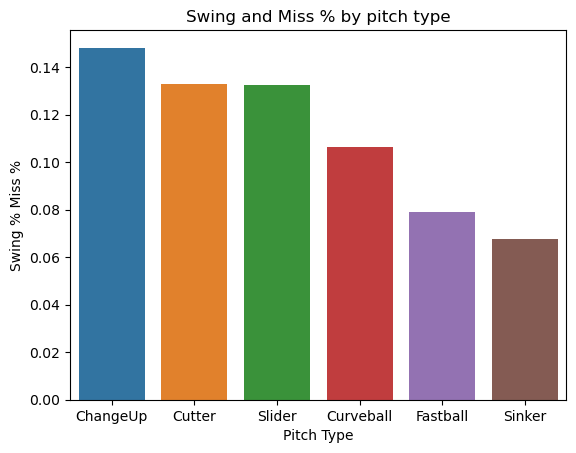

In [30]:
# Visualize swing-and-miss percentage by pitch type
# This bar chart clearly shows which pitch types are most effective at generating whiffs
sns.barplot(data=miss_pct, x='TaggedPitchType', y='swing_and_miss_percentage', hue='TaggedPitchType')
plt.xlabel('Pitch Type')
plt.ylabel('Swing & Miss %')
plt.title('Swing and Miss % by Pitch Type')
plt.xticks(rotation=45)  # Rotate labels for better readability

Text(0.5, 1.0, 'Righty Pitch Movement')

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


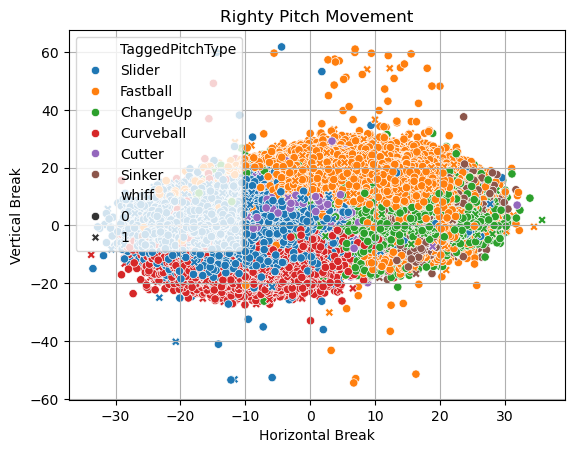

In [31]:
# Analyze pitch movement patterns for right-handed pitchers
# This scatter plot shows how different pitch types cluster in movement space
# The 'style' parameter differentiates whiffs (triangles) from non-whiffs (circles)

right = pitching[pitching['PitcherThrows'] == 'Right']
sns.scatterplot(data=right, x='HorzBreak', y='InducedVertBreak', 
                hue='TaggedPitchType', style='whiff', alpha=0.6)
plt.grid(True, alpha=0.3)
plt.xlabel('Horizontal Break (inches)')
plt.ylabel('Induced Vertical Break (inches)')
plt.title('Right-Handed Pitcher Movement Profile')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

Text(0.5, 1.0, 'Lefty Pitch Movement')

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


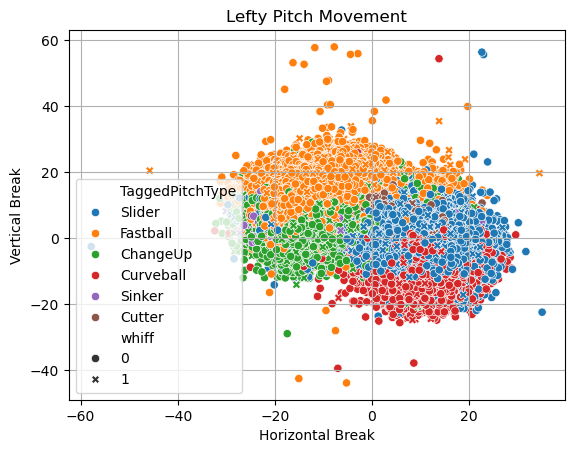

In [32]:
# Analyze pitch movement patterns for left-handed pitchers
# Left-handed pitchers typically show mirror-image movement patterns compared to righties
# This is important for understanding handedness-specific pitch effectiveness

left = pitching[pitching['PitcherThrows'] == 'Left']
sns.scatterplot(data=left, x='HorzBreak', y='InducedVertBreak', 
                hue='TaggedPitchType', style='whiff', alpha=0.6)
plt.grid(True, alpha=0.3)
plt.xlabel('Horizontal Break (inches)')
plt.ylabel('Induced Vertical Break (inches)')
plt.title('Left-Handed Pitcher Movement Profile')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [33]:
# Calculate average movement characteristics for pitches that resulted in swing-and-miss
# This analysis identifies the "sweet spot" movement profiles for each pitch type
swinging = pitching[pitching['whiff'] == 1]
ave_pitch_swing = swinging[['TaggedPitchType', 'InducedVertBreak', 'HorzBreak']].groupby('TaggedPitchType').mean().reset_index()
ave_pitch_swing

,TaggedPitchType,InducedVertBreak,HorzBreak
0,ChangeUp,6.954868,4.618877
1,Curveball,-8.270059,-4.053708
2,Cutter,5.802714,-1.083866
3,Fastball,16.328012,3.861719
4,Sinker,8.585094,8.246034
5,Slider,0.840454,-3.590647


Text(0.5, 1.0, 'Average Pitch Location Resulting in Swing and Miss')

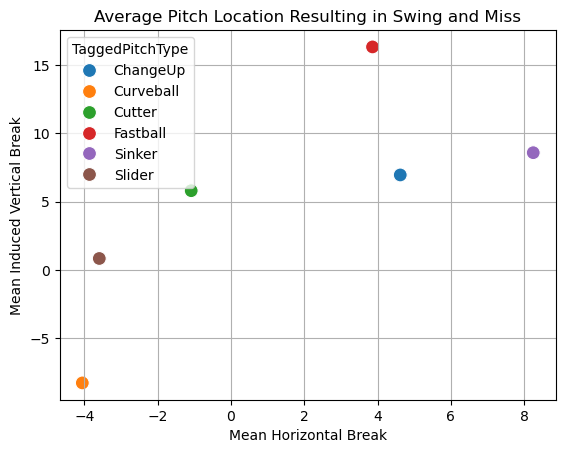

In [34]:
# Visualize the average movement "sweet spots" for swing-and-miss
# Larger markers make it easier to see the optimal movement characteristics per pitch type
sns.scatterplot(data=ave_pitch_swing, x='HorzBreak', y='InducedVertBreak', 
                hue='TaggedPitchType', s=200)
plt.grid(True, alpha=0.3)
plt.xlabel('Mean Horizontal Break (inches)')
plt.ylabel('Mean Induced Vertical Break (inches)')
plt.title('Average Movement Profile for Swing-and-Miss Pitches')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [35]:
# Compare average movement between whiffs and non-whiffs for each pitch type
# This analysis helps identify if there are systematic differences in movement
# between successful (whiff) and unsuccessful pitches
ave_pitch = pitching[['TaggedPitchType', 'whiff', 'InducedVertBreak', 'HorzBreak']].groupby(['TaggedPitchType', 'whiff']).mean().reset_index()
ave_pitch


,TaggedPitchType,whiff,InducedVertBreak,HorzBreak
0,ChangeUp,0,7.087114,4.594422
1,ChangeUp,1,6.954868,4.618877
2,Curveball,0,-8.247228,-4.100595
3,Curveball,1,-8.270059,-4.053708
4,Cutter,0,6.267498,-0.811615
5,Cutter,1,5.802714,-1.083866
6,Fastball,0,15.399737,4.441060
7,Fastball,1,16.328012,3.861719
8,Sinker,0,8.776947,8.459111
9,Sinker,1,8.585094,8.246034


Text(0.5, 1.0, 'Average Pitch Location Resulting in Swing and Miss')

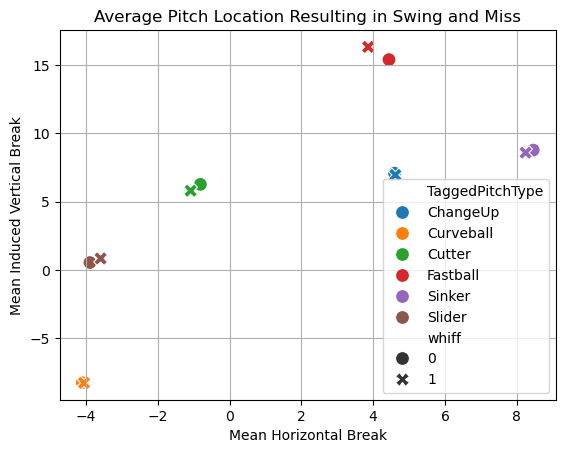

In [36]:
# Visualize movement differences between whiffs and non-whiffs
# Circles represent non-whiffs (0), triangles represent whiffs (1)
# This helps identify if certain movement ranges are more effective
sns.scatterplot(data=ave_pitch, x='HorzBreak', y='InducedVertBreak', 
                hue='TaggedPitchType', s=200, style='whiff')
plt.grid(True, alpha=0.3)
plt.xlabel('Mean Horizontal Break (inches)')
plt.ylabel('Mean Induced Vertical Break (inches)')
plt.title('Movement Comparison: Whiffs vs Non-Whiffs by Pitch Type')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [37]:
# Split dataset into pitch type categories for specialized modeling
# Different pitch categories have different movement patterns and effectiveness factors
# This allows for more targeted model development for each pitch family

# Fastball family: Fastball, Sinker, Cutter (velocity-focused pitches)
fb = pitching[(pitching['TaggedPitchType'] == 'Fastball') | 
              (pitching['TaggedPitchType'] == 'Sinker') | 
              (pitching['TaggedPitchType'] == 'Cutter')]

# Breaking ball family: Curveball, Slider (spin-heavy, sharp break pitches)
bb = pitching[(pitching['TaggedPitchType'] == 'Curveball') | 
              (pitching['TaggedPitchType'] == 'Slider')]

# Offspeed family: ChangeUp (deception-based pitch)
off = pitching[pitching['TaggedPitchType'] == 'ChangeUp']

# Key Findings from Exploratory Data Analysis

## Data Complexity and Feature Importance
The exploratory analysis revealed that swing-and-miss prediction involves numerous variables beyond just pitch movement. While movement characteristics (horizontal and vertical break) are important, the analysis shows that the average difference in movement between whiff and non-whiff pitches is relatively small, suggesting that other factors play crucial roles.

## Important Variables Identified
Through examination of the dataset, several key variables emerged as potentially influential for whiff prediction:
- **Pitch characteristics**: Velocity, spin rate, movement profile
- **Game situation**: Count (balls-strikes), number of outs
- **Matchup dynamics**: Pitcher handedness vs batter handedness
- **Location**: Release point, plate location, approach angles

## Surprising Insights
Despite fastballs being the most frequently thrown pitch type, they have the second-lowest swing-and-miss rate among the six main pitch types. This suggests that while fastballs are effective for strikes and contact, they may not be optimal for generating whiffs compared to breaking balls and offspeed pitches. It's also possible that since Fastballs are often a pitcher's main pitch there are many pitchers who are throwing less effective Fastballs that may be skewing this data

## Modeling Strategy
Based on the distinct movement patterns and effectiveness profiles observed, the analysis supports exploration on developing three separate models:

1. **Fastball Model**: Fastballs, Sinkers, Cutters (velocity-focused pitches)
2. **Breaking Ball Model**: Curveballs, Sliders (spin-heavy, movement-focused pitches) 
3. **Offspeed Model**: ChangeUps (deception-based pitches)

This approach allows each model to learn the specific characteristics that make each pitch family effective at generating swing-and-miss outcomes.

In [38]:
pitching

,PitcherThrows,BatterSide,Outs,Balls,Strikes,TaggedPitchType,PitchCall,RelSpeed,VertRelAngle,HorzRelAngle,...,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,VertApprAngle,HorzApprAngle,PitcherId,whiff,count
0,Right,Right,0,0,0,Slider,BallCalled,86.34831,-5.087035,-0.556059,...,5.20061,-1.26150,-6.71201,-1.24052,-0.79734,-12.231122,-1.751516,1.000234e+09,0,0-0
1,Right,Right,0,1,0,Fastball,StrikeCalled,94.49974,-3.133086,-0.492520,...,5.83655,20.20828,3.49654,3.00046,0.29788,-5.365324,0.134391,1.000234e+09,0,1-0
2,Right,Right,0,1,1,Fastball,FoulBallNotFieldable,94.81021,-3.910073,-1.135525,...,5.67326,22.06875,-0.43740,2.48669,-0.87744,-5.815582,-1.213668,1.000234e+09,0,1-1
3,Right,Right,0,1,2,Slider,FoulBallNotFieldable,86.30865,-1.385858,-0.791508,...,5.43599,2.34610,-6.38485,2.69703,-1.15108,-7.862841,-1.929632,1.000234e+09,0,1-2
4,Right,Right,0,1,2,Slider,BallCalled,87.45870,-4.605749,-1.323250,...,5.28786,0.27646,-4.37162,-0.43496,-1.44974,-11.264591,-2.102031,1.000234e+09,0,1-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506010,Right,Left,1,0,2,Fastball,StrikeSwinging,92.18631,0.167760,-2.363777,...,5.16822,12.64422,18.25938,3.18957,0.77831,-3.753137,0.867156,6.945510e+05,1,0-2
1506011,Right,Right,2,0,0,Fastball,StrikeCalled,92.64280,-0.263162,-3.510955,...,5.05159,15.40280,13.05642,3.09837,-0.84427,-3.653929,-1.209960,6.945510e+05,0,0-0
1506012,Right,Right,2,0,1,Fastball,StrikeSwinging,93.60782,-0.195835,-2.925634,...,5.29399,17.26068,10.25316,3.60768,-0.76626,-3.090463,-1.109277,6.945510e+05,1,0-1
1506013,Right,Right,2,0,2,Fastball,BallCalled,92.70635,1.555863,-3.913135,...,5.42663,16.00694,10.33784,4.86704,-1.41462,-1.669483,-2.081033,6.945510e+05,0,0-2


In [39]:
# Save the cleaned and processed dataset for future modeling work
# This preserves all the data cleaning and feature engineering steps
pitching.to_csv('./whiff_csvs/2024_whiff_clean.csv', index=False)

print(f"Cleaned dataset saved with {len(pitching)} rows and {len(pitching.columns)} columns")
print(f"Whiff rate in cleaned data: {pitching['whiff'].mean():.3f}")